In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import classification_report as report
from sklearn.preprocessing import MinMaxScaler

### Load data


In [102]:
#lab data, extracted from mimic, preprocessed
lab = pd.read_csv("patients_no_text_sepsis_labels.csv")
#forecasts from strats model, trained on train data, and then tasked to forecast test patients that it did never encounter during training. It got 4 hours of input and forecast 12 next hours.
notext_forecasts = pd.read_pickle("strats_base_test.pkl")
forecasts = notext_forecasts[0]
var_map = list(notext_forecasts[1].keys())

In [163]:
targets = lab[["m:icustayid", "sepsis_label", "step"]]
rows = lab.drop(columns=["m:icustayid", "sepsis_label","m:charttime", "traj", "step", "r:reward", "a:action","Unnamed: 0", "Unnamed: 0.1", "m:presumed_onset", "o:cumulated_balance", "o:re_admission", "o:output_4hourly", "o:output_total", "o:PaO2_FiO2", "o:input_total"])
var_map=list(rows.columns)
scaler = MinMaxScaler()
rows[rows.columns] = scaler.fit_transform(rows[rows.columns])

rows["m:icustayid"] = targets["m:icustayid"]
rows["sepsis_label"] = targets["sepsis_label"]
rows["step"] = targets["step"]

min_max = pd.DataFrame({"min": rows.min(), "max": rows.max()})
min_max

,min,max
o:Arterial_BE,0.0,1.0
o:Arterial_lactate,0.0,1.0
o:Arterial_pH,0.0,1.0
o:BUN,0.0,1.0
o:Calcium,0.0,1.0
o:Chloride,0.0,1.0
o:Creatinine,0.0,1.0
o:DiaBP,0.0,1.0
o:FiO2_1,0.0,1.0
o:GCS,0.0,1.0


In [159]:
var_map

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:Creatinine',
 'o:DiaBP',
 'o:FiO2_1',
 'o:GCS',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:MeanBP',
 'o:PT',
 'o:PTT',
 'o:Platelets_count',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:SIRS',
 'o:SOFA',
 'o:Shock_Index',
 'o:Sodium',
 'o:SpO2',
 'o:SysBP',
 'o:Temp_C',
 'o:Total_bili',
 'o:WBC_count',
 'o:Weight_kg',
 'o:age',
 'o:gender',
 'o:input_4hourly',
 'o:max_dose_vaso',
 'o:mechvent',
 'o:paCO2',
 'o:paO2']

In [133]:
from scipy import stats

def drop_numerical_outliers(df, z_thresh=3):
    return df[(np.abs(stats.zscore(df)) < z_thresh).all(axis=1)]


In [129]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [134]:
missing_values_table(rows)

Your selected dataframe has 43 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [141]:
n = drop_numerical_outliers(rows, z_thresh=3)
n

,m:icustayid,o:Arterial_BE,o:Arterial_lactate,o:Arterial_pH,o:BUN,o:Calcium,o:Chloride,o:Creatinine,o:DiaBP,o:FiO2_1,...,o:WBC_count,o:Weight_kg,o:age,o:gender,o:input_4hourly,o:max_dose_vaso,o:mechvent,o:paCO2,o:paO2,sepsis_label
6,200003.0,1.071661,-0.972746,1.069870,-0.999098,-1.024640,1.007303,-0.656311,-0.096861,-1.324664,...,0.298152,-0.165619,-0.963438,-0.5,0.347576,-2.302585,-0.5,-0.374712,-0.689066,1
7,200003.0,1.071661,-0.972746,1.069870,-0.999098,-1.024640,1.007303,-0.656311,-0.125706,-1.324664,...,0.298152,-0.165619,-0.963438,-0.5,0.347576,-2.302585,-0.5,-0.374712,-0.689066,1
8,200003.0,1.071661,-0.972746,1.069870,-0.999098,-1.024640,1.007303,-0.656311,-0.060804,-0.279641,...,0.298152,-0.165619,-0.963438,-0.5,0.347576,-2.302585,-0.5,-0.374712,-0.689066,1
9,200003.0,-0.086635,2.161392,-0.290388,-0.999098,-1.024640,1.007303,-0.656311,-0.039169,-1.324664,...,0.298152,-0.165619,-0.963438,-0.5,0.347576,-2.302585,-0.5,0.342991,2.502016,1
10,200003.0,-0.086635,2.161392,-0.290388,-0.999098,-1.024640,1.007303,-0.656311,0.036551,-1.324664,...,0.298152,-0.165619,-0.963438,-0.5,0.347576,-2.302585,-0.5,0.342991,2.502016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991934,299999.0,-0.019540,-0.744383,-0.112773,-0.519833,0.095193,0.191409,-0.065567,-0.062706,-0.340459,...,0.755655,0.258350,-0.849940,-0.5,-0.329454,-2.302585,-0.5,-0.076793,-0.483898,0
1991935,299999.0,-0.019540,-0.744383,-0.112773,-0.519833,0.095193,0.191409,-0.065567,-0.033424,-0.340459,...,0.755655,0.258350,-0.849940,-0.5,-1.056430,-2.302585,-0.5,-0.076793,-0.483898,0
1991936,299999.0,-0.019540,-0.744383,-0.112773,-0.519833,0.095193,0.191409,-0.065567,-0.040745,-0.340459,...,0.755655,0.258350,-0.849940,-0.5,-1.056430,-2.302585,-0.5,-0.076793,-0.483898,0
1991937,299999.0,-0.019540,-0.744383,-0.112773,-0.519833,0.095193,0.191409,-0.065567,-0.037084,-0.340459,...,0.755655,0.258350,-0.849940,-0.5,-1.056430,-2.302585,-0.5,-0.076793,-0.483898,0


In [136]:
rows.describe()

,m:icustayid,o:Arterial_BE,o:Arterial_lactate,o:Arterial_pH,o:BUN,o:Calcium,o:Chloride,o:Creatinine,o:DiaBP,o:FiO2_1,...,o:WBC_count,o:Weight_kg,o:age,o:gender,o:input_4hourly,o:max_dose_vaso,o:mechvent,o:paCO2,o:paO2,sepsis_label
count,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,...,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06,1.991939e+06
mean,2.499964e+05,-2.397085e-18,1.410463e-16,4.104135e-14,-1.618603e-16,-6.130402e-16,-6.764660e-15,1.961900e-17,1.221929e-16,1.678851e-16,...,-2.287932e-16,5.715478e-16,-1.332836e-15,-6.825335e-02,-1.268458e-17,-2.170558e+00,-2.202595e-01,-2.292840e-15,4.179489e-16,4.464158e-01
std,2.890576e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,4.953197e-01,1.000000e+00,4.301755e-01,4.488718e-01,1.000000e+00,1.000000e+00,4.971206e-01
min,2.000030e+05,-1.090518e+01,-1.550087e+00,-7.180108e+01,-7.955582e+00,-1.145663e+01,-1.679163e+01,-4.163450e+00,-2.689363e+00,-2.479690e+00,...,-1.692483e+00,-3.522239e+00,-2.775468e+00,-5.000000e-01,-1.417028e+00,-2.302585e+00,-5.000000e-01,-4.374527e+00,-1.491731e+00,0.000000e+00
25%,2.249070e+05,-5.379041e-01,-5.935605e-01,-4.847101e-01,-6.566401e-01,-5.843257e-01,-5.962046e-01,-6.097886e-01,-6.636667e-02,-5.652610e-01,...,-5.458869e-01,-6.614513e-01,-6.533086e-01,-5.000000e-01,-1.056430e+00,-2.302585e+00,-5.000000e-01,-6.009071e-01,-7.294590e-01,0.000000e+00
50%,2.500070e+05,-1.954019e-02,-2.304499e-01,9.825751e-02,-7.960458e-02,-2.944955e-02,1.226456e-02,-2.284475e-01,-7.801794e-03,-2.796406e-01,...,-1.585233e-01,-1.284318e-01,9.459865e-02,-5.000000e-01,2.880607e-01,-2.302585e+00,-5.000000e-01,-1.816161e-01,-4.063115e-01,0.000000e+00
75%,2.750360e+05,4.988237e-01,3.113721e-01,5.840638e-01,6.441497e-01,5.925442e-01,5.496967e-01,3.465666e-01,5.442339e-02,2.703717e-01,...,3.373022e-01,4.975741e-01,7.930249e-01,5.000000e-01,8.958044e-01,-2.302585e+00,5.000000e-01,3.429908e-01,4.829659e-01,1.000000e+00
max,2.999990e+05,2.589865e+01,2.037071e+01,6.553564e+00,4.095757e+00,1.545232e+01,7.715458e+00,8.335615e+00,6.590247e+02,3.481176e+00,...,7.468013e+01,9.293319e+00,1.616612e+00,5.000000e-01,2.433977e+00,5.242678e+00,5.000000e-01,1.638038e+01,4.153773e+00,1.000000e+00


In [103]:
def restore_predictions(predictions, mapping):
    l = []
    leng = len(predictions.iloc[0]) / len(mapping)
    for i in range(len(predictions)):
        arr = np.asarray(predictions.iloc[i]).reshape((int(leng),len(mapping)))
        l.append(arr)
    df = pd.concat([pd.DataFrame(arr) for arr in l])#, keys=np.arange(len(l)))
    
    df.columns=mapping
    return df

In [104]:
fo_IDs = forecasts["SUBJECT_ID"]
observe = lab.loc[lab["m:icustayid"].isin(fo_IDs)]
observe_targets = observe[var_map][(observe['step'] >= 5) & (observe['step'] <= 16)]
step = observe["step"][(observe['step'] >= 5) & (observe['step'] <= 16)]
step = step-4
st = pd.DataFrame(step, columns=["step"])
st = st.reset_index().drop(columns="index")
fo = restore_predictions(forecasts["forecasting_pred"], var_map)
observe_targets = observe_targets.reset_index().drop(columns="index")
fo = fo.reset_index().drop(columns="index")
MSE = np.mean((fo - observe_targets)**2, axis=1)
print(len(st))
st["mse"] = MSE
st



47076


,step,mse
0,1,0.370591
1,2,0.379599
2,3,0.500888
3,4,0.636272
4,5,0.771316
...,...,...
47071,8,0.966541
47072,9,0.994655
47073,10,1.071681
47074,11,1.076444


In [111]:
v_mse = np.mean((fo - observe_targets)**2, axis=0)
v_mse

o:Arterial_BE         1.585838
o:Arterial_lactate    1.374924
o:Arterial_pH         1.203708
o:BUN                 1.775562
o:Calcium             1.429229
o:Chloride            3.107003
o:Creatinine          1.392736
o:DiaBP               0.035566
o:FiO2_1              1.363674
o:GCS                 1.913900
o:Glucose             1.917800
o:HCO3                1.458840
o:HR                  1.326965
o:Hb                  2.004261
o:INR                 1.827403
o:Magnesium           1.629014
o:MeanBP              0.078243
o:PT                  1.734378
o:PTT                 0.683298
o:Platelets_count     2.772281
o:Potassium           1.985064
o:RR                  1.052194
o:SGOT                1.194375
o:SGPT                1.185071
o:SIRS                1.313255
o:SOFA                1.144378
o:Shock_Index         1.246271
o:Sodium              3.097410
o:SpO2                0.963790
o:SysBP               1.286398
o:Temp_C              1.805277
o:Total_bili          1.160580
o:WBC_co

In [94]:
f = st.groupby("step").mean()
f

Index(['mse'], dtype='object')

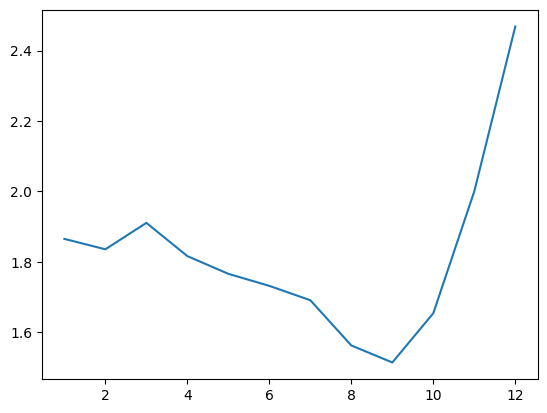

In [100]:
plt.plot(list(f.index), f["mse"])

47076


,step,mse
0,1,0.816162
1,2,0.882372
2,3,1.694132
3,4,1.437500
4,5,1.340938
...,...,...
47071,8,0.449088
47072,9,0.492502
47073,10,0.768750
47074,11,0.746236


In [4]:
def get_forecast_mse(observed, fore, IDs):
    temp = fore[["SUBJECT_ID", "forecasting_pred"]]

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred,forecasting_test_op
0,5,4,200011.0,1,"[0.49304988980293274, -0.05062102526426315, -0...","[0.8400016372490969, -0.8902682310165556, -1.5..."
1,38,4,200079.0,0,"[-0.750440239906311, -0.6006877422332764, -1.9...","[-0.0195401924382678, 0.0097278901485559, 0.46..."
2,98,4,200224.0,0,"[0.6830044388771057, 0.22860786318778992, -1.3...","[1.0171875777582011, -0.8952046714397234, 1.33..."
3,103,4,200232.0,0,"[-1.0842230319976807, 0.051913827657699585, -1...","[-0.2787221349873852, 0.9900714985358582, 1.19..."
4,121,4,200281.0,0,"[-0.1251840889453888, 0.5443605780601501, -0.2...","[0.2396417501108494, 4.45897965129093, -0.2576..."
...,...,...,...,...,...,...
3918,43327,4,299861.0,0,"[-1.2931568622589111, 0.5706110000610352, -1.5...","[-1.833813790282089, 1.0654825453348815, -1.56..."
3919,43348,4,299911.0,0,"[-0.582378625869751, 0.3418247401714325, -1.44...","[-0.0195401924382678, 1.9704151069231617, 0.17..."
3920,43367,4,299955.0,1,"[0.8641371726989746, -0.4484887719154358, 0.20...","[1.0716606948959595, -0.6428363572216266, 0.97..."
3921,43378,4,299976.0,0,"[0.5391132235527039, -0.3913000226020813, -1.1...","[-0.0519379352569075, 0.6130162645407418, -0.3..."


In [155]:
#list of all variables
var_map

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:Creatinine',
 'o:DiaBP',
 'o:FiO2_1',
 'o:GCS',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:MeanBP',
 'o:PT',
 'o:PTT',
 'o:Platelets_count',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:SIRS',
 'o:SOFA',
 'o:Shock_Index',
 'o:Sodium',
 'o:SpO2',
 'o:SysBP',
 'o:Temp_C',
 'o:Total_bili',
 'o:WBC_count',
 'o:Weight_kg',
 'o:input_4hourly',
 'o:input_total',
 'o:max_dose_vaso',
 'o:mechvent',
 'o:paCO2',
 'o:paO2']

### Experiments on 16hours observed data. Without any forecasting, this is the performance benchmark given "perfect" data.

In [156]:
#test, train and val IDs were determined through GroupKFold splitting, ensuring that no patient is in more than one set.
IDs = pd.read_csv("IDs.csv")
train_IDs = np.unique(IDs["train_ids"][~np.isnan(IDs["train_ids"])])
test_IDs = np.unique(IDs["test_ids"][~np.isnan(IDs["test_ids"])])
val_IDs = np.unique(IDs["val_ids"][~np.isnan(IDs["val_ids"])])
print(np.intersect1d(train_IDs,test_IDs))
print(np.intersect1d(train_IDs,val_IDs))
print(np.intersect1d(test_IDs,val_IDs))


[]
[]
[]


### Prepare data
#### Train a classifier on train data, full 16hours
##### the two cells below only need to run once, to obtain concatenated and trimmed patient data.

In [164]:
# classifying time series data works through concatenating all timesteps. This results in an input of #ofvariables*timesteps.
min_step = 16
thresh = min_step*(len(var_map)) 
# data for Classifier 1: trained on 16hours observed data, only lab features
#temp_ = lab.copy()
#temp_["granular_label"] = np.where(((temp_["m:charttime"] >= temp_["m:presumed_onset"]) & (temp_["m:presumed_onset"] > 0.0)), 1, 0)
#rows = temp_.drop(columns=["m:charttime", "traj", "r:reward", "a:action", "o:output_4hourly", "o:output_total", "o:PaO2_FiO2", "Unnamed: 0", "Unnamed: 0.1", "m:presumed_onset", "o:SOFA", "o:SIRS", "o:input_4hourly", "o:input_total", "o:GCS", "o:PTT", "o:DiaBP", "o:MeanBP", "o:SpO2", "o:cumulated_balance", "o:Creatinine", "o:Platelets_count", "o:re_admission", "o:mechvent", "o:max_dose_vaso"])
r = rows.copy()
r = r.loc[r["step"]<=16]

indexes = []
target = []
for id in tqdm(np.unique(r["m:icustayid"])):
    df_ = r["sepsis_label"].loc[r["m:icustayid"]==id]
    target.append(np.unique(df_).item())
    indexes.append(id)
ground_truths = pd.DataFrame({"m:icustayid": indexes,
                              "sepsis_label": target})

r.drop(columns=["step", "sepsis_label"], inplace=True)
temp2 = []
for ind in tqdm(ground_truths["m:icustayid"]):
    df_ = r[var_map].loc[r["m:icustayid"]==ind]
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_.values.flatten()))
df_ = r[var_map].loc[r["m:icustayid"]==ind]

# trim data to equal length for classification
preprocessed_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_data)}, {len(preprocessed_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truths)}")
print(f"length of desired patient data: {thresh}")


100%|██████████| 43388/43388 [17:35<00:00, 41.09it/s]


shape of preprocessed data: [43388, 656]
number of patients: 43388
length of ground truth: 43388
length of desired patient data: 656


In [165]:
sequenced_data = ground_truths.copy()
sequenced_data["16hr_sequence"] = preprocessed_data
sequenced_data.to_pickle("Experiments/Scenario_1_Forecasts/no_text_SCALEDnurzumTEST.pkl")
sequenced_data

,m:icustayid,sepsis_label,16hr_sequence
0,200003.0,1,"[0.325423755442839, 0.04515015997140498, 0.930..."
1,200006.0,0,"[0.29577464788732394, 0.10899858963106997, 0.9..."
2,200007.0,0,"[0.2746478873239437, 0.04363555180477778, 0.91..."
3,200009.0,0,"[0.33098591549295775, 0.026434752376806148, 0...."
4,200010.0,0,"[0.29225352112676056, 0.03675523203358914, 0.9..."
...,...,...,...
43383,299988.0,1,"[0.26877391253586935, 0.08277529328090914, 0.9..."
43384,299992.0,1,"[0.28136276651519593, 0.05267518663330581, 0.9..."
43385,299993.0,0,"[0.2699530516431925, 0.04707571169037211, 0.92..."
43386,299995.0,1,"[0.29395162049452256, 0.07525026661900831, 0.9..."


##### start here to load the preprocessed classification data

In [166]:
sequenced_data = pd.read_pickle("Experiments/Scenario_1_Forecasts/no_text_SCALEDnurzumTEST.pkl")


##### data for one patient is 16 (# of timesteps) x 27 (# of variables) = 432 long. At the moment it's all observed data.

In [167]:
t = sequenced_data["16hr_sequence"][0]
len(t)

656

### Split data in train and test sets, according to predetermined patient IDs and then bring in correct form for the classifier

In [168]:
train_val_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(np.concatenate([train_IDs, val_IDs]))]
train_val_data = pd.DataFrame(train_val_cohort["16hr_sequence"].tolist())
print("Traindata labelcounts:")
Counter(train_val_cohort["sepsis_label"])


Traindata labelcounts:


Counter({0: 19375, 1: 6043})

In [169]:
#the cohort holds IDs and sequences, but really is just used temporary
train_val_cohort.head()

,m:icustayid,sepsis_label,16hr_sequence
1,200006.0,0,"[0.29577464788732394, 0.10899858963106997, 0.9..."
2,200007.0,0,"[0.2746478873239437, 0.04363555180477778, 0.91..."
3,200009.0,0,"[0.33098591549295775, 0.026434752376806148, 0...."
4,200010.0,0,"[0.29225352112676056, 0.03675523203358914, 0.9..."
8,200016.0,0,"[0.29577464788732394, 0.026434752376806148, 0...."


In [170]:
#this is the data that is fed into the classifier
train_val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,646,647,648,649,650,651,652,653,654,655
0,0.295775,0.108999,0.918620,0.617006,0.393939,0.590646,0.339752,0.003975,0.396592,0.961662,...,0.249630,0.015284,0.274667,0.508474,0.0,0.093637,0.0,1.0,0.181818,0.089985
1,0.274648,0.043636,0.911222,0.617006,0.479798,0.678365,0.314824,0.004130,0.321166,0.961662,...,0.215019,0.015825,0.420000,0.367701,0.0,0.619986,0.0,0.0,0.212121,0.204644
2,0.330986,0.026435,0.929717,0.586572,0.393939,0.678365,0.277301,0.003986,0.255169,0.961662,...,0.215019,0.027389,0.290667,0.422961,1.0,0.093637,0.0,1.0,0.212121,0.187228
3,0.292254,0.036755,0.915846,0.617006,0.489899,0.685675,0.327855,0.004119,0.321166,0.961662,...,0.249630,0.020085,0.164333,0.156528,1.0,0.093637,0.0,0.0,0.242424,0.166909
4,0.295775,0.026435,0.911222,0.570895,0.383838,0.780703,0.284314,0.004097,0.255169,0.961662,...,0.322529,0.012781,0.213333,0.681229,1.0,0.614911,0.0,0.0,0.202020,0.634253


##### do the same for test data

In [171]:
test_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(test_IDs)]
test_data = pd.DataFrame(test_cohort["16hr_sequence"].tolist())

In [172]:
test_cohort.head()

,m:icustayid,sepsis_label,16hr_sequence
5,200011.0,1,"[0.325423755442839, 0.033862619978553735, 0.89..."
29,200062.0,0,"[0.3028169014084507, 0.05395603146156076, 0.92..."
38,200079.0,0,"[0.23239436619718312, 0.05051587157596643, 0.9..."
49,200112.0,1,"[0.30654047447384913, 0.12792545325231414, 0.9..."
98,200224.0,0,"[0.3028169014084507, 0.08147731054631535, 0.91..."


In [173]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,646,647,648,649,650,651,652,653,654,655
0,0.325424,0.033863,0.899014,0.751414,0.429284,0.673933,0.402877,0.003423,0.276812,1.000000,...,0.263090,0.015289,0.335106,0.902327,1.0,0.000000,0.000000,0.0,0.356971,0.064904
1,0.302817,0.053956,0.920470,0.677332,0.373737,0.692985,0.327855,0.004022,0.255169,0.961662,...,0.409327,0.017042,0.273333,0.697422,0.0,0.093637,0.000000,0.0,0.166667,0.108853
2,0.232394,0.050516,0.900125,0.726429,0.479798,0.692985,0.379086,0.003997,0.622870,0.961662,...,0.249630,0.022520,0.286667,0.887327,0.0,0.389127,0.000000,0.0,0.181818,0.545718
3,0.306540,0.127925,0.917614,0.741101,0.475513,0.706648,0.402877,0.003220,0.369082,0.533333,...,0.241740,0.022252,0.547255,0.584551,1.0,0.000000,0.000000,0.0,0.175427,0.580062
4,0.302817,0.081477,0.913071,0.809808,0.373737,0.576027,0.693909,0.004301,0.321166,0.961662,...,0.170399,0.014810,0.216333,0.243440,0.0,0.093637,0.000000,0.0,0.242424,0.121916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,0.281690,0.119319,0.916771,0.850817,0.484848,0.546787,0.507743,0.003925,0.255169,0.961662,...,0.215019,0.024751,0.211667,0.783400,1.0,0.093637,0.000000,0.0,0.202020,0.130624
5080,0.316901,0.053956,0.913071,0.691801,0.368687,0.656435,0.337840,0.003981,0.434305,0.961662,...,0.215019,0.028809,0.325667,0.893737,0.0,0.093637,0.195758,0.0,0.207071,0.139332
5081,0.296469,0.112875,0.910174,0.641706,0.443153,0.647761,0.263672,0.003678,0.922705,0.933333,...,0.215610,0.018108,0.217747,0.893525,0.0,0.458219,0.000000,0.0,0.192717,0.096386
5082,0.309859,0.057396,0.913071,0.726429,0.459596,0.656435,0.461571,0.004041,0.434305,0.961662,...,0.322529,0.018462,0.273333,0.527946,0.0,0.311911,0.000000,0.0,0.257576,0.185776


#### "train_test_split" the train data, note that no test data is used here

In [174]:
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_cohort["sepsis_label"], test_size=0.30, random_state=100,stratify=train_val_cohort["sepsis_label"])
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_val)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_val).items())


Shape of X_train: 17792
Shape of X_test: 7626
Class Balance in Training Data: dict_items([(1, 4230), (0, 13562)])
Class Balance in Test Data: dict_items([(0, 5813), (1, 1813)])


### Train classifier to predict Sepsis Label after 16 hours' worth of data. This is on fully observed data.

In [175]:
clf = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1, verbose=1, random_state=111))

In [176]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=111,
                                        verbose=1))])

#### First, evaluate on the validation set, obtained by train_test_split, then on the held out test data that only contains patients that were not in the train/val data.

In [177]:
print("Score on validation set obtained through train_test_split:", clf.score(X_val, y_val))
pr_forest = clf.predict(test_data)
print("Scores on Testpatients, not observed during training: \n",report(y_true=test_cohort["sepsis_label"], y_pred=pr_forest))
auc(y_true=test_cohort["sepsis_label"], y_score=pr_forest)

Score on validation set obtained through train_test_split: 1.0
Scores on Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3896
           1       1.00      1.00      1.00      1188

    accuracy                           1.00      5084
   macro avg       1.00      1.00      1.00      5084
weighted avg       1.00      1.00      1.00      5084



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9990299124026023

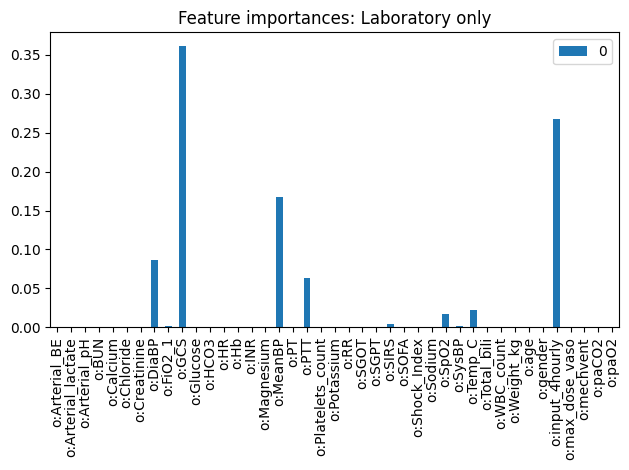

In [178]:
importances = clf[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf[1].estimators_], axis=0)
feature_names = var_map*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances: Laboratory only")
fig.tight_layout()


### Combine 4 hours observed test with 12 hours forecast data.
#### Take 4xlen(var_map) columns from test_data (this corresponds to 4hours of observed data) and concat 12xlen(var_map) of the forecast data.

In [227]:
forecast_IDs = list(np.unique(forecasts["SUBJECT_ID"]))
forecast_observed_cohort = test_cohort.loc[test_cohort["m:icustayid"].isin(forecast_IDs)]

In [228]:
forecast_observed_cohort

,m:icustayid,sepsis_label,16hr_sequence
5,200011.0,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
38,200079.0,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
98,200224.0,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."
103,200232.0,0,"[0.2396417501108494, -0.2919162970475371, 0.90..."
121,200281.0,0,"[-0.5379040775365025, 3.176991855707534, -2.43..."
...,...,...,...
43327,299861.0,0,"[-0.5379040775365025, 1.0654825453348815, 0.03..."
43348,299911.0,0,"[0.7580056352090841, -0.3673273438465604, -0.2..."
43367,299955.0,1,"[0.0060290297203905, 0.9242321768129234, -0.48..."
43378,299976.0,0,"[0.4988236926599667, -0.2919162970475371, -0.2..."


#### observed data (only of test patients not seen during training)

In [229]:
forecast_observed_data = pd.DataFrame(forecast_observed_cohort["16hr_sequence"].tolist())
forecast_observed_data

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.336055,1.456557,-0.710920,-0.274723,...,0.149712,0.956892,1.524676,-1.181768,0.086192,0.992814,1.451676,-0.524785,0.772330,3.034376
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,-0.333974,-1.346165,-0.080743,-3.161464,...,1.091367,3.024911,1.305415,-0.345283,0.331061,-0.121375,0.291403,0.027411,0.151554,-0.600907
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.625936,2.632624,0.237570,1.328996,...,-1.086723,-1.930147,-1.582514,-0.840224,-0.376929,0.396713,0.318975,-0.561381,-0.749807,0.656966
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.723257,-0.409980,-0.214090,1.380611,...,-0.888715,0.515745,1.632311,0.151393,-0.848922,-0.639462,0.346548,-0.344458,0.950390,1.128669
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,0.288879,1.228346,0.734397,1.741912,...,-0.492698,-0.553828,-0.122232,0.120264,-1.320916,-0.403968,0.263830,-0.143029,0.706895,-0.076793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,0.249951,-0.878073,1.682884,1.070924,...,-0.492698,-0.840627,0.034327,0.603619,-2.500899,0.161219,0.401694,0.197851,-0.809613,-0.181616
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,-0.100404,0.526206,-0.665751,0.916080,...,0.101326,-1.090800,0.034327,-0.981012,-0.848922,0.208318,0.291403,0.507742,0.651361,-0.076793
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,2.252655,0.660432,-0.132015,0.001811,...,-0.644771,0.504483,-0.467386,3.029355,0.478608,-1.696373,0.050815,-0.309555,-0.731694,-0.374712
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,-0.684329,-0.644026,0.237570,0.090248,...,-0.492698,-1.022161,-0.542739,-0.617189,0.331061,1.244493,0.291403,-0.282480,-0.019320,0.971434


#### trim to 4 hours

In [230]:
len_obs = 4*len(var_map) 
obs = forecast_observed_data.iloc[:,:len_obs]
print(len_obs, obs.head())

96          0         1         2         3         4         5         6   \
0  1.071661 -0.807791 -1.359161  1.099965  0.094949 -0.275503 -0.336055   
1 -2.352178 -0.442738 -1.272136  0.798865  1.454231  0.191409 -0.333974   
2  0.239642  0.235961 -0.257693  1.803683 -1.399749 -2.674896 -0.625936   
3  0.239642 -0.291916  0.901670 -0.763379 -1.807460  0.191409 -0.723257   
4 -0.537904  3.176992 -2.431498  1.365751 -1.263845 -2.316608  0.288879   

         7         8         9   ...        86        87        88        89  \
0  1.456557 -0.710920 -0.274723  ... -0.238702 -0.080548 -0.018693 -0.959008   
1 -1.346165 -0.080743 -3.161464  ...  0.274584 -0.957924  0.572208  0.411471   
2  2.632624  0.237570  1.328996  ... -0.096682 -1.930147 -1.582514 -1.087175   
3 -0.409980 -0.214090  1.380611  ... -1.086723  2.121107  2.550452  0.846463   
4  1.228346  0.734397  1.741912  ... -0.245188  0.310268  0.449475  0.389239   

         90        91        92        93        94        95  
0

#### obtain 12 hours of forecast data from strats

In [231]:
forecast_preds_data = pd.DataFrame(forecasts["forecasting_pred"].tolist())
forecast_preds_data

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,0.493050,-0.050621,-0.025556,1.145061,-0.286043,0.061803,-0.234417,0.955016,-0.135415,0.430664,...,2.890893,-1.244744,-1.036866,2.527963,-1.263870,-1.094509,0.747718,1.565909,-1.301901,-0.241045
1,-0.750440,-0.600688,-1.998078,1.825367,1.453903,0.799050,0.954882,-0.629476,-0.178539,-2.304444,...,2.755935,-2.369779,-1.941759,2.168590,-2.259792,-1.802261,0.603047,0.355440,-0.787282,-0.101517
2,0.683004,0.228608,-1.392878,1.178243,-1.008511,-2.100470,-0.051254,1.948591,0.098627,1.208308,...,1.443214,-1.994676,-1.343120,3.973701,-1.576721,-2.745610,-0.069945,1.029862,-1.314076,-0.853841
3,-1.084223,0.051914,-1.023236,-0.334742,0.168217,-0.123762,0.145992,0.194671,0.731991,0.526950,...,1.884757,-0.142879,-0.381789,0.909828,-1.441706,-0.166477,0.777894,0.214810,-1.069772,-0.416477
4,-0.125184,0.544361,-0.260379,0.852094,-1.102330,-1.743152,-0.358680,0.678401,0.215163,1.228460,...,1.741047,-1.164068,-1.172316,1.054826,-1.842461,-0.050731,0.362560,0.040630,-0.867716,-0.332966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-1.293157,0.570611,-1.524998,2.177876,1.036234,-3.151882,-0.003270,-0.569139,-0.648798,0.397187,...,3.045675,-1.882929,-1.502435,2.602756,-2.054517,-1.443161,0.095187,1.512146,-1.328800,-0.339363
3919,-0.582379,0.341825,-1.442169,0.327180,-0.337821,0.778230,0.507897,-0.070335,0.523966,0.616883,...,1.025268,1.272594,1.052281,0.161339,-1.744368,-0.021127,0.923290,0.346359,-0.873218,-0.502482
3920,0.864137,-0.448489,0.203011,0.897756,0.359037,0.345747,-0.218900,0.051884,0.600700,0.076265,...,1.241849,0.967477,0.321582,0.942372,-1.456159,-1.081211,0.843060,0.298084,-1.001532,-0.610962
3921,0.539113,-0.391300,-1.162537,0.567775,0.375087,0.751656,0.630884,0.740021,-0.336490,-1.011883,...,2.301376,-0.372695,-0.433516,0.644640,-1.486696,0.073531,0.828313,-0.030809,-1.044596,-0.195223


#### concat 4 hours observed with 12 hours forecast (which strats did forecast after being trained on trainset and observing 4hours of test data as input)

In [232]:
forecast_test_data = pd.concat([obs, forecast_preds_data], axis=1)
forecast_test_data

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.336055,1.456557,-0.710920,-0.274723,...,2.890893,-1.244744,-1.036866,2.527963,-1.263870,-1.094509,0.747718,1.565909,-1.301901,-0.241045
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,-0.333974,-1.346165,-0.080743,-3.161464,...,2.755935,-2.369779,-1.941759,2.168590,-2.259792,-1.802261,0.603047,0.355440,-0.787282,-0.101517
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.625936,2.632624,0.237570,1.328996,...,1.443214,-1.994676,-1.343120,3.973701,-1.576721,-2.745610,-0.069945,1.029862,-1.314076,-0.853841
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.723257,-0.409980,-0.214090,1.380611,...,1.884757,-0.142879,-0.381789,0.909828,-1.441706,-0.166477,0.777894,0.214810,-1.069772,-0.416477
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,0.288879,1.228346,0.734397,1.741912,...,1.741047,-1.164068,-1.172316,1.054826,-1.842461,-0.050731,0.362560,0.040630,-0.867716,-0.332966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,0.249951,-0.878073,1.682884,1.070924,...,3.045675,-1.882929,-1.502435,2.602756,-2.054517,-1.443161,0.095187,1.512146,-1.328800,-0.339363
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,-0.100404,0.526206,-0.665751,0.916080,...,1.025268,1.272594,1.052281,0.161339,-1.744368,-0.021127,0.923290,0.346359,-0.873218,-0.502482
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,2.252655,0.660432,-0.132015,0.001811,...,1.241849,0.967477,0.321582,0.942372,-1.456159,-1.081211,0.843060,0.298084,-1.001532,-0.610962
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,-0.684329,-0.644026,0.237570,0.090248,...,2.301376,-0.372695,-0.433516,0.644640,-1.486696,0.073531,0.828313,-0.030809,-1.044596,-0.195223


#### Use the classifier trained on 16 hours of observed data.

In [234]:
prediction_on_forecast = clf.predict(forecast_test_data)
print("Scores on 4hour observed data + 12 hour forecast. \nOnly Testpatients, not observed during training: \n",report(y_true=forecast_observed_cohort["sepsis_label"], y_pred=prediction_on_forecast))
auc(y_true=forecast_observed_cohort["sepsis_label"], y_score=prediction_on_forecast)

Scores on 4hour observed data + 12 hour forecast. 
Only Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.90      0.37      0.53      3070
           1       0.27      0.85      0.41       853

    accuracy                           0.48      3923
   macro avg       0.59      0.61      0.47      3923
weighted avg       0.76      0.48      0.50      3923



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6106714756502247

#### Unfortunately, the classifier is not able to utilize the forecast data in any meaningful way. Almost all predictions are label 1.

In [30]:
Counter(prediction_on_forecast)

Counter({1: 2641, 0: 1282})

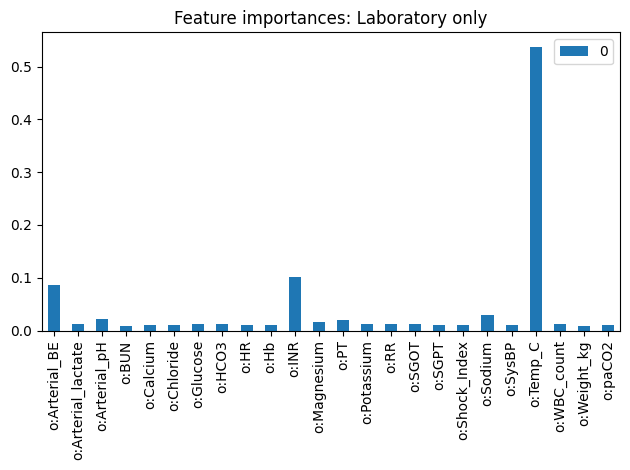

In [311]:
importances = clf[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf[1].estimators_], axis=0)
feature_names = var_map*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances: Laboratory only")
fig.tight_layout()


### Now include tfidf data, obtained by training an classifier to find septic patients utilizing only tfidf data from patient notes.

#### Lab + Tfidf was used to train another strats model which was used to obtain the following forecasts.

In [178]:
lab_tfidf = pd.read_csv("lab_noteevents_tfidf_for_strats_no_SOFA.csv")
text_forecasts_ = pd.read_pickle("Experiments/Scenario_1_Forecasts/4OBS12forecasting_text_preds_test_no_SOFA_FIX.pkl")
text_forecasts = text_forecasts_[0]
var_map_text = list(text_forecasts_[1].keys())


In [179]:
var_map_text

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:PT',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:Shock_Index',
 'o:Sodium',
 'o:SysBP',
 'o:Temp_C',
 'o:WBC_count',
 'o:Weight_kg',
 'o:paCO2',
 'tfidf:0',
 'tfidf:1',
 'tfidf:10',
 'tfidf:11',
 'tfidf:12',
 'tfidf:13',
 'tfidf:14',
 'tfidf:15',
 'tfidf:16',
 'tfidf:17',
 'tfidf:18',
 'tfidf:19',
 'tfidf:2',
 'tfidf:20',
 'tfidf:21',
 'tfidf:22',
 'tfidf:23',
 'tfidf:24',
 'tfidf:25',
 'tfidf:26',
 'tfidf:27',
 'tfidf:28',
 'tfidf:29',
 'tfidf:3',
 'tfidf:30',
 'tfidf:31',
 'tfidf:32',
 'tfidf:33',
 'tfidf:34',
 'tfidf:35',
 'tfidf:36',
 'tfidf:37',
 'tfidf:38',
 'tfidf:39',
 'tfidf:4',
 'tfidf:40',
 'tfidf:41',
 'tfidf:42',
 'tfidf:43',
 'tfidf:44',
 'tfidf:45',
 'tfidf:46',
 'tfidf:47',
 'tfidf:48',
 'tfidf:49',
 'tfidf:5',
 'tfidf:6',
 'tfidf:7',
 'tfidf:8',
 'tfidf:9']

In [183]:
text_IDs = np.unique(lab_tfidf["m:icustayid"])

In [184]:
text_truths = lab_tfidf[["m:icustayid","sepsis_label"]].loc[lab_tfidf["m:icustayid"].isin(text_IDs)]
text_truths

,m:icustayid,sepsis_label
0,202134,1
1,202134,1
2,202134,1
3,202134,1
4,202134,1
...,...,...
1978153,234115,1
1978154,234115,1
1978155,234115,1
1978156,234115,1


#### create the concatenated patient data that is necessary for a classifier
#### the next two cells only need to run once to obtain the preprocessed data.

In [185]:
min_step = 16
thresh = min_step*len(var_map_text)
# data for Classifier 1: trained on 16hours observed data, lab + tfidf features
temp_ = lab_tfidf.copy()

indexes = []
target = []
for id in tqdm(np.unique(temp_["m:icustayid"])):
    df_ = lab["sepsis_label"].loc[lab["m:icustayid"]==id]
    target.append(np.unique(df_).item())
    indexes.append(id)
ground_truths = pd.DataFrame({"m:icustayid": indexes,
                              "sepsis_label": target})

temp2 = []
for ind in tqdm(ground_truths["m:icustayid"]):
    df_ = lab_tfidf[var_map_text].loc[lab_tfidf["m:icustayid"]==ind]
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_.values.flatten()))

# trim data to equal length for classification
preprocessed_text_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_text_data)}, {len(preprocessed_text_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truths)}")
print(f"length of desired patient data: {thresh}")


100%|██████████| 41774/41774 [1:22:39<00:00,  8.42it/s]


shape of preprocessed data: [41774, 1184]
number of patients: 41774
length of ground truth: 41774
length of desired patient data: 1184


In [187]:
sequenced_data = ground_truths.copy()
sequenced_data["16hr_sequence"] = preprocessed_text_data
sequenced_data.to_pickle("Experiments/Scenario_1_Forecasts/lab+tfidf_FIX.pkl")
sequenced_data

,m:icustayid,sepsis_label,16hr_sequence
0,200003,1,"[1.0716606948959595, -0.5603590659566504, 1.06..."
1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
...,...,...,...
41769,299988,1,"[-1.013270823925806, 0.264413846693113, -0.679..."
41770,299992,1,"[-0.5499527086320803, -0.3954044834266977, -0...."
41771,299993,0,"[-0.9698739817850311, -0.518149437444607, 0.85..."
41772,299995,1,"[-0.0866345933383545, 0.0994592641631602, -0.5..."


#### load concatenated patient data

In [235]:
sequenced_data = pd.read_pickle("Experiments/Scenario_1_Forecasts/lab+tfidf_FIX.pkl")


#### build train and test sets according to the predetermined patient IDs
##### as before, train_val* is used for training a classifier, test is used to test said classifier and then 4 hours of test data is combined with 12 hours of forecast data obtained by a strats model which was also trained on train_val patients. That way we can compare how good our prediction of septic patients is based on forecast data, with and without textual information.

In [236]:
train_val_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(np.concatenate([train_IDs, val_IDs]))]
train_val_data = pd.DataFrame(train_val_cohort["16hr_sequence"].tolist())
Counter(train_val_cohort["sepsis_label"])

Counter({0: 19375, 1: 6043})

In [237]:
train_val_cohort.head()

,m:icustayid,sepsis_label,16hr_sequence
1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
7,200016,0,"[-0.0195401924382678, -0.9706157182387468, -0...."


##### data for this classifier is longer, because we use 50 more features

In [238]:
train_val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183
0,-0.019540,0.839249,0.177068,-0.519833,-0.856133,-2.316608,1.768155,1.696438,-0.244201,0.658008,...,0.000000,0.000000,0.000000,0.0,0.000000,0.511845,0.000000,0.0,0.000000,0.000000
1,-0.797086,-0.593560,-0.402613,-0.519833,1.454231,-0.166879,2.741363,-0.409980,0.418234,2.255154,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,1.276370,-0.970616,1.046590,-0.886600,-0.856133,-0.166879,-0.840042,0.760253,-1.418519,0.709622,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,-0.149131,-0.744383,-0.040313,-0.519833,1.726039,0.012265,1.009053,0.058113,1.562441,-1.045270,...,0.034852,0.581086,0.043404,0.0,0.235461,0.104876,0.116466,0.0,0.017256,0.000000
4,-0.019540,-0.970616,-0.402613,-1.075529,-1.127941,2.341137,-0.859506,-0.878073,-0.891581,0.606393,...,0.072353,0.527768,0.000000,0.0,0.139661,0.000000,0.040297,0.0,0.035823,0.045015


In [239]:
test_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(test_IDs)]
test_data = pd.DataFrame(test_cohort["16hr_sequence"].tolist())

In [240]:
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_cohort["sepsis_label"], test_size=0.30, random_state=100,stratify=train_val_cohort["sepsis_label"])
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_val)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_val).items())


Shape of X_train: 17792
Shape of X_test: 7626
Class Balance in Training Data: dict_items([(1, 4230), (0, 13562)])
Class Balance in Test Data: dict_items([(0, 5813), (1, 1813)])


#### train classifier with lab+tfidf data 16 hours observed

In [241]:
clf_text = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1, verbose=1, random_state=576))


In [242]:
clf_text.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=576,
                                        verbose=1))])

In [243]:
print("Score:", clf_text.score(X_val, y_val))
pr_forest = clf_text.predict(test_data)
print("Scores on Testpatients, not observed during training: \n",report(y_true=test_cohort["sepsis_label"], y_pred=pr_forest))
auc(y_true=test_cohort["sepsis_label"], y_score=pr_forest)

Score: 0.9583005507474429
Scores on Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      3896
           1       0.96      0.85      0.90      1188

    accuracy                           0.96      5084
   macro avg       0.96      0.92      0.94      5084
weighted avg       0.96      0.96      0.96      5084



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9194014926817803

In [244]:
forecast_IDs = list(np.unique(text_forecasts["SUBJECT_ID"]))
forecast_observed_cohort = test_cohort.loc[test_cohort["m:icustayid"].isin(forecast_IDs)]

In [245]:
forecast_observed_cohort

,m:icustayid,sepsis_label,16hr_sequence
5,200011,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
36,200079,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
96,200224,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."
101,200232,0,"[0.2396417501108494, -0.2919162970475371, 0.90..."
118,200281,0,"[-0.5379040775365025, 3.176991855707534, -2.43..."
...,...,...,...
41715,299861,0,"[-0.5379040775365025, 1.0654825453348815, 0.03..."
41735,299911,0,"[0.7580056352090841, -0.3673273438465604, -0.2..."
41753,299955,1,"[0.0060290297203905, 0.9242321768129234, -0.48..."
41764,299976,0,"[0.4988236926599667, -0.2919162970475371, -0.2..."


#### build 4 hours of observed data and combine with the forecast data

In [246]:
forecast_observed_data = pd.DataFrame(forecast_observed_cohort["16hr_sequence"].tolist())
forecast_observed_data

,0,1,2,3,4,5,6,7,8,9,...,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.336055,1.456557,-0.710920,-0.274723,...,0.079351,0.854435,0.000000,0.0,0.000000,0.000000,0.044195,0.000000,0.013096,0.000000
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,-0.333974,-1.346165,-0.080743,-3.161464,...,0.074743,0.000000,0.000000,0.0,0.000000,0.149942,0.083257,0.000000,0.000000,0.372018
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.625936,2.632624,0.237570,1.328996,...,0.000000,0.000000,0.000000,0.0,0.183942,0.000000,0.000000,0.405157,0.188723,0.000000
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.723257,-0.409980,-0.214090,1.380611,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.548597,0.000000,0.000000,0.000000
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,0.288879,1.228346,0.734397,1.741912,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,0.249951,-0.878073,1.682884,1.070924,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.175985,0.000000,0.000000,0.000000
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,-0.100404,0.526206,-0.665751,0.916080,...,0.000000,0.000000,0.000000,0.0,0.000000,0.369094,0.000000,0.000000,0.000000,0.000000
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,2.252655,0.660432,-0.132015,0.001811,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.254454,0.000000,0.000000,0.000000
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,-0.684329,-0.644026,0.237570,0.090248,...,0.000000,0.000000,0.205561,0.0,0.000000,0.496686,0.367720,0.000000,0.000000,0.000000


In [247]:
len_obs = 4*len(var_map_text) 
obs = forecast_observed_data.iloc[:,:len_obs]
print(len_obs, obs.head())

296         0         1         2         3         4         5         6    \
0  1.071661 -0.807791 -1.359161  1.099965  0.094949 -0.275503 -0.336055   
1 -2.352178 -0.442738 -1.272136  0.798865  1.454231  0.191409 -0.333974   
2  0.239642  0.235961 -0.257693  1.803683 -1.399749 -2.674896 -0.625936   
3  0.239642 -0.291916  0.901670 -0.763379 -1.807460  0.191409 -0.723257   
4 -0.537904  3.176992 -2.431498  1.365751 -1.263845 -2.316608  0.288879   

        7         8         9    ...       286       287       288  289  \
0  1.456557 -0.710920 -0.274723  ...  0.079351  0.854435  0.000000  0.0   
1 -1.346165 -0.080743 -3.161464  ...  0.066636  0.000000  0.000000  0.0   
2  2.632624  0.237570  1.328996  ...  0.000000  0.000000  0.000000  0.0   
3 -0.409980 -0.214090  1.380611  ...  0.000000  0.000000  0.223849  0.0   
4  1.228346  0.734397  1.741912  ...  0.091134  0.000000  0.000000  0.0   

        290       291       292  293       294       295  
0  0.000000  0.000000  0.044195  0.

In [248]:
forecast_preds_data = pd.DataFrame(text_forecasts["forecasting_pred"].tolist())
forecast_preds_data

,0,1,2,3,4,5,6,7,8,9,...,878,879,880,881,882,883,884,885,886,887
0,0.551731,-0.447173,-0.028495,0.249251,0.082033,-0.266310,-0.202691,0.753551,-1.309169,0.112833,...,0.069679,0.034690,0.090764,-0.400850,0.150010,0.148966,0.100581,0.151110,0.078579,0.131472
1,-0.867211,-0.743279,0.065228,0.913241,0.560093,0.540871,0.349833,-0.656540,0.474935,-2.298610,...,0.070988,0.020907,0.100812,-0.468007,0.126031,0.135704,0.149885,0.120726,0.075421,0.168350
2,1.083542,-0.496396,-0.517264,1.364253,-0.761197,-1.079119,0.086624,1.705576,-0.247027,0.321055,...,0.051393,0.040044,0.093150,-0.459204,0.152749,0.147097,0.118756,0.183160,0.099662,0.149058
3,-0.119219,-0.376428,0.189542,-0.594830,0.222678,-0.358258,0.204112,-0.411145,0.679955,0.708857,...,0.060428,0.028259,0.110906,-0.483165,0.147063,0.152925,0.137620,0.178829,0.103658,0.167704
4,-0.768717,1.252704,-2.157939,2.158194,-0.690122,-2.501733,-0.516294,0.765971,-0.322320,1.441336,...,0.059727,0.061039,0.080747,-0.445667,0.206867,0.262630,0.039214,0.329832,0.167622,0.109464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-1.015788,0.587761,-0.839448,2.095861,1.579732,-1.895854,0.286007,-1.224365,1.356980,0.097310,...,0.067266,0.050885,0.055848,-0.405284,0.130904,0.150042,0.074000,0.160028,0.093021,0.152759
3919,0.106399,-0.338843,0.269773,0.001359,-0.463959,0.669554,0.186277,0.002617,0.642209,0.799236,...,0.061718,0.029812,0.081592,-0.445072,0.123377,0.119626,0.128045,0.122938,0.070723,0.153707
3920,0.110411,-0.245215,-0.430428,0.481694,0.383189,0.336327,0.486349,0.500110,0.236363,0.093711,...,0.075322,0.027138,0.124997,-0.415970,0.129499,0.191598,0.092267,0.169525,0.107457,0.164608
3921,0.380752,0.280796,-0.819822,0.488840,0.292084,-0.446765,0.590185,0.402792,1.064062,-1.275658,...,0.086279,0.027894,0.108469,-0.500902,0.143273,0.138130,0.144928,0.143261,0.092822,0.195165


In [249]:
forecast_test_data = pd.concat([obs, forecast_preds_data], axis=1)
forecast_test_data

,0,1,2,3,4,5,6,7,8,9,...,878,879,880,881,882,883,884,885,886,887
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.336055,1.456557,-0.710920,-0.274723,...,0.069679,0.034690,0.090764,-0.400850,0.150010,0.148966,0.100581,0.151110,0.078579,0.131472
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,-0.333974,-1.346165,-0.080743,-3.161464,...,0.070988,0.020907,0.100812,-0.468007,0.126031,0.135704,0.149885,0.120726,0.075421,0.168350
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.625936,2.632624,0.237570,1.328996,...,0.051393,0.040044,0.093150,-0.459204,0.152749,0.147097,0.118756,0.183160,0.099662,0.149058
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.723257,-0.409980,-0.214090,1.380611,...,0.060428,0.028259,0.110906,-0.483165,0.147063,0.152925,0.137620,0.178829,0.103658,0.167704
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,0.288879,1.228346,0.734397,1.741912,...,0.059727,0.061039,0.080747,-0.445667,0.206867,0.262630,0.039214,0.329832,0.167622,0.109464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,0.249951,-0.878073,1.682884,1.070924,...,0.067266,0.050885,0.055848,-0.405284,0.130904,0.150042,0.074000,0.160028,0.093021,0.152759
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,-0.100404,0.526206,-0.665751,0.916080,...,0.061718,0.029812,0.081592,-0.445072,0.123377,0.119626,0.128045,0.122938,0.070723,0.153707
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,2.252655,0.660432,-0.132015,0.001811,...,0.075322,0.027138,0.124997,-0.415970,0.129499,0.191598,0.092267,0.169525,0.107457,0.164608
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,-0.684329,-0.644026,0.237570,0.090248,...,0.086279,0.027894,0.108469,-0.500902,0.143273,0.138130,0.144928,0.143261,0.092822,0.195165


#### use same classifier to predict labels based on 4 hours observed and 12 hours forecast data from strats

In [250]:
prediction_on_forecast = clf_text.predict(forecast_test_data)
print("Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: \n",report(y_true=forecast_observed_cohort["sepsis_label"], y_pred=prediction_on_forecast))
auc(y_true=forecast_observed_cohort["sepsis_label"], y_score=prediction_on_forecast)

Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      3070
           1       0.78      0.42      0.55       853

    accuracy                           0.85      3923
   macro avg       0.82      0.69      0.73      3923
weighted avg       0.84      0.85      0.83      3923



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6948308518316271

##### By utilizing tfidf data, our classifier performs signifcantly better.

In [205]:
Counter(prediction_on_forecast)

Counter({0: 3459, 1: 464})

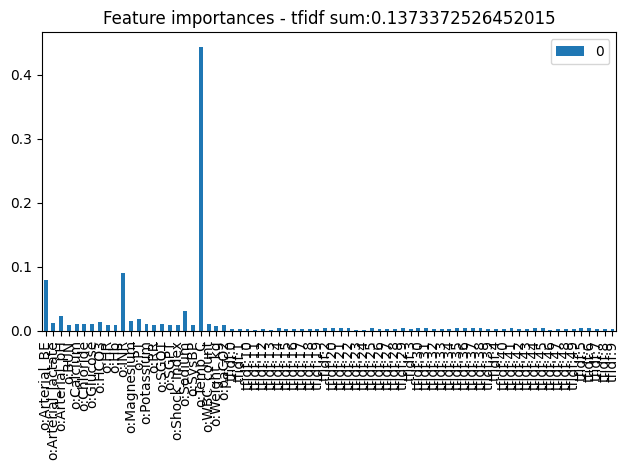

In [308]:
importances = clf_text[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_text[1].estimators_], axis=0)
feature_names = var_map_text*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
count = imp.loc[imp.index.str.contains('tfidf'), imp.columns].sum()
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances - tfidf sum:{count.item()}")
fig.tight_layout()


### Now include sBert embeddings

#### Lab + sBert was used to train another strats model which was used to obtain the following forecasts.

In [57]:
lab_sBert = pd.read_csv("lab_sBert_concat_fulldata.csv")
text_forecasts_ = pd.read_pickle("Experiments/Scenario_1_Forecasts/4OBS12forecasting_text_preds_test_sBert_no_SOFA.pkl")
text_forecasts = text_forecasts_[0]
var_map_text_sBert = list(text_forecasts_[1].keys())


In [58]:
var_map_text_sBert

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:PT',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:Shock_Index',
 'o:Sodium',
 'o:SysBP',
 'o:Temp_C',
 'o:WBC_count',
 'o:Weight_kg',
 'o:paCO2',
 'sBert:0',
 'sBert:1',
 'sBert:10',
 'sBert:11',
 'sBert:12',
 'sBert:13',
 'sBert:14',
 'sBert:15',
 'sBert:16',
 'sBert:17',
 'sBert:18',
 'sBert:19',
 'sBert:2',
 'sBert:20',
 'sBert:21',
 'sBert:22',
 'sBert:23',
 'sBert:24',
 'sBert:25',
 'sBert:26',
 'sBert:27',
 'sBert:28',
 'sBert:29',
 'sBert:3',
 'sBert:30',
 'sBert:31',
 'sBert:4',
 'sBert:5',
 'sBert:6',
 'sBert:7',
 'sBert:8',
 'sBert:9']

In [59]:
text_IDs = np.unique(lab["m:icustayid"])

In [60]:
text_truths = lab[["m:icustayid","sepsis_label"]].loc[lab["m:icustayid"].isin(text_IDs)]
text_truths

,m:icustayid,sepsis_label
0,200003.0,1
1,200003.0,1
2,200003.0,1
3,200003.0,1
4,200003.0,1
...,...,...
1991934,299999.0,0
1991935,299999.0,0
1991936,299999.0,0
1991937,299999.0,0


#### create the concatenated patient data that is necessary for a classifier
#### the next two cells only need to run once to obtain the preprocessed data.

In [62]:
min_step = 16
thresh = min_step*len(var_map_text_sBert)
# data for Classifier 1: trained on 16hours observed data, lab + tfidf features
temp_ = lab_sBert.copy()

indexes = []
target = []
for id in tqdm(np.unique(temp_["m:icustayid"])):
    df_ = lab["sepsis_label"].loc[lab["m:icustayid"]==id]
    target.append(np.unique(df_).item())
    indexes.append(id)
ground_truths = pd.DataFrame({"m:icustayid": indexes,
                              "sepsis_label": target})

temp2 = []
for ind in tqdm(ground_truths["m:icustayid"]):
    df_ = lab_sBert[var_map_text_sBert].loc[lab_sBert["m:icustayid"]==ind]
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(df_.values.flatten()))

# trim data to equal length for classification
preprocessed_text_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_text_data)}, {len(preprocessed_text_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truths)}")
print(f"length of desired patient data: {thresh}")


100%|██████████| 41774/41774 [1:01:51<00:00, 11.25it/s]


shape of preprocessed data: [41774, 896]
number of patients: 41774
length of ground truth: 41774
length of desired patient data: 896


In [63]:
sequenced_data = ground_truths.copy()
sequenced_data["16hr_sequence"] = preprocessed_text_data
#sequenced_data.to_pickle("Experiments/Scenario_1_Forecasts/lab+s_BERT.pkl")
sequenced_data

,m:icustayid,sepsis_label,16hr_sequence
0,200003,1,"[1.0716606948959595, -0.5603590659566504, 1.06..."
1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
...,...,...,...
41769,299988,1,"[-1.013270823925806, 0.264413846693113, -0.679..."
41770,299992,1,"[-0.5499527086320803, -0.3954044834266977, -0...."
41771,299993,0,"[-0.9698739817850311, -0.518149437444607, 0.85..."
41772,299995,1,"[-0.0866345933383545, 0.0994592641631602, -0.5..."


#### load concatenated patient data

In [291]:
sequenced_data = pd.read_pickle("Experiments/Scenario_1_Forecasts/lab+s_BERT.pkl")
text_forecasts_ = pd.read_pickle("Experiments/Scenario_1_Forecasts/4OBS12forecasting_text_preds_test_sBert_no_SOFA.pkl")
text_forecasts = text_forecasts_[0]
var_map_text_sBert = list(text_forecasts_[1].keys())


#### build train and test sets according to the predetermined patient IDs
##### as before, train_val* is used for training a classifier, test is used to test said classifier and then 4 hours of test data is combined with 12 hours of forecast data obtained by a strats model which was also trained on train_val patients. That way we can compare how good our prediction of septic patients is based on forecast data, with and without textual information.

In [292]:
train_val_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(np.concatenate([train_IDs, val_IDs]))]
train_val_data = pd.DataFrame(train_val_cohort["16hr_sequence"].tolist())
Counter(train_val_cohort["sepsis_label"])

Counter({0: 19375, 1: 6043})

In [293]:
train_val_cohort.head()

,m:icustayid,sepsis_label,16hr_sequence
1,200006,0,"[-0.0195401924382678, 0.8392494049378121, 0.17..."
2,200007,0,"[-0.7970860200856198, -0.5935604842436303, -0...."
3,200009,0,"[1.2763695203073189, -0.9706157182387468, 1.04..."
4,200010,0,"[-0.1491311637128265, -0.7443825778416768, -0...."
7,200016,0,"[-0.0195401924382678, -0.9706157182387468, -0...."


##### data for this classifier is longer, because we use 50 more features

In [294]:
train_val_data.head()

,0,1,2,3,4,5,6,7,8,9,...,886,887,888,889,890,891,892,893,894,895
0,-0.019540,0.839249,0.177068,-0.519833,-0.856133,-2.316608,1.768155,1.696438,-0.244201,0.658008,...,-0.048843,0.036530,0.013175,-0.093648,0.070102,-0.074058,0.098017,-0.251503,0.001572,-0.020767
1,-0.797086,-0.593560,-0.402613,-0.519833,1.454231,-0.166879,2.741363,-0.409980,0.418234,2.255154,...,0.021328,-0.040359,0.028285,-0.110488,-0.078340,-0.196124,-0.101987,-0.272847,-0.069477,0.088116
2,1.276370,-0.970616,1.046590,-0.886600,-0.856133,-0.166879,-0.840042,0.760253,-1.418519,0.709622,...,-0.046530,0.119966,0.059132,-0.118762,-0.064846,-0.179691,-0.147846,-0.340764,-0.097445,-0.058355
3,-0.149131,-0.744383,-0.040313,-0.519833,1.726039,0.012265,1.009053,0.058113,1.562441,-1.045270,...,-0.069298,0.123715,0.065286,-0.063597,-0.093426,-0.062556,0.067214,-0.307858,-0.043762,0.023189
4,-0.019540,-0.970616,-0.402613,-1.075529,-1.127941,2.341137,-0.859506,-0.878073,-0.891581,0.606393,...,0.016116,0.093001,0.128761,-0.092669,0.072417,-0.140739,-0.043366,-0.216038,0.003582,0.076563


In [295]:
test_cohort = sequenced_data.loc[sequenced_data["m:icustayid"].isin(test_IDs)]
test_data = pd.DataFrame(test_cohort["16hr_sequence"].tolist())

In [296]:
X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_cohort["sepsis_label"], test_size=0.30, random_state=100,stratify=train_val_cohort["sepsis_label"])
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_val)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_val).items())


Shape of X_train: 17792
Shape of X_test: 7626
Class Balance in Training Data: dict_items([(1, 4230), (0, 13562)])
Class Balance in Test Data: dict_items([(0, 5813), (1, 1813)])


#### train classifier with lab+tfidf data 16 hours observed

In [297]:
clf_text_sBert = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1, verbose=1, random_state=2024)) #2024


In [298]:
clf_text_sBert.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2024,
                                        verbose=1))])

In [299]:
print("Score:", clf_text_sBert.score(X_val, y_val))
pr_forest = clf_text_sBert.predict(test_data)
print("Scores on Testpatients, not observed during training: \n",report(y_true=test_cohort["sepsis_label"], y_pred=pr_forest))
auc(y_true=test_cohort["sepsis_label"], y_score=pr_forest)

Score: 0.9598741148701809
Scores on Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      3896
           1       0.96      0.87      0.91      1188

    accuracy                           0.96      5084
   macro avg       0.96      0.93      0.94      5084
weighted avg       0.96      0.96      0.96      5084



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9271773173210544

In [300]:
forecast_IDs = list(np.unique(text_forecasts["SUBJECT_ID"]))
forecast_observed_cohort = test_cohort.loc[test_cohort["m:icustayid"].isin(forecast_IDs)]

In [301]:
forecast_observed_cohort

,m:icustayid,sepsis_label,16hr_sequence
5,200011,1,"[1.0716606948959595, -0.8077909397515792, -1.3..."
36,200079,0,"[-2.352177675380324, -0.4427383906455838, -1.2..."
96,200224,0,"[0.2396417501108494, 0.2359610305456256, -0.25..."
101,200232,0,"[0.2396417501108494, -0.2919162970475371, 0.90..."
118,200281,0,"[-0.5379040775365025, 3.176991855707534, -2.43..."
...,...,...,...
41715,299861,0,"[-0.5379040775365025, 1.0654825453348815, 0.03..."
41735,299911,0,"[0.7580056352090841, -0.3673273438465604, -0.2..."
41753,299955,1,"[0.0060290297203905, 0.9242321768129234, -0.48..."
41764,299976,0,"[0.4988236926599667, -0.2919162970475371, -0.2..."


#### build 4 hours of observed data and combine with the forecast data

In [302]:
forecast_observed_data = pd.DataFrame(forecast_observed_cohort["16hr_sequence"].tolist())
forecast_observed_data

,0,1,2,3,4,5,6,7,8,9,...,886,887,888,889,890,891,892,893,894,895
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.336055,1.456557,-0.710920,-0.274723,...,0.000532,0.234056,0.049997,-0.042811,-0.174802,-0.100519,0.111183,-0.443813,-0.105152,-0.110541
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,-0.333974,-1.346165,-0.080743,-3.161464,...,-0.003735,0.008152,0.059569,0.040271,0.215500,-0.019677,-0.167447,-0.411514,0.087382,-0.007158
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.625936,2.632624,0.237570,1.328996,...,-0.083519,0.262833,-0.017846,-0.082946,-0.121326,0.060702,-0.145589,-0.322625,-0.049575,0.056536
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.723257,-0.409980,-0.214090,1.380611,...,0.008104,-0.117039,0.017781,-0.040276,-0.153256,0.012181,-0.042749,-0.329220,0.069891,0.080585
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,0.288879,1.228346,0.734397,1.741912,...,-0.047830,0.106499,0.130329,-0.023301,0.138471,0.006639,0.042135,-0.130865,-0.004346,0.053635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,0.249951,-0.878073,1.682884,1.070924,...,-0.038656,-0.189553,-0.088807,-0.100326,-0.043972,-0.043567,-0.179575,-0.236921,-0.039623,0.079906
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,-0.100404,0.526206,-0.665751,0.916080,...,0.009356,0.008187,-0.022061,0.036842,-0.091296,0.043367,-0.230568,-0.198416,-0.036765,-0.000408
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,2.252655,0.660432,-0.132015,0.001811,...,-0.002394,0.018623,0.048585,-0.085412,-0.070955,0.037460,0.000059,-0.510723,0.036410,-0.061946
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,-0.684329,-0.644026,0.237570,0.090248,...,-0.022873,-0.005279,0.142403,-0.101234,-0.018897,0.040222,-0.276890,-0.396722,-0.002637,0.022172


In [303]:
len_obs = 4*len(var_map_text_sBert) 
obs = forecast_observed_data.iloc[:,:len_obs]
print(len_obs, obs.head())

224         0         1         2         3         4         5         6    \
0  1.071661 -0.807791 -1.359161  1.099965  0.094949 -0.275503 -0.336055   
1 -2.352178 -0.442738 -1.272136  0.798865  1.454231  0.191409 -0.333974   
2  0.239642  0.235961 -0.257693  1.803683 -1.399749 -2.674896 -0.625936   
3  0.239642 -0.291916  0.901670 -0.763379 -1.807460  0.191409 -0.723257   
4 -0.537904  3.176992 -2.431498  1.365751 -1.263845 -2.316608  0.288879   

        7         8         9    ...       214       215       216       217  \
0  1.456557 -0.710920 -0.274723  ...  0.000532  0.234056  0.049997 -0.042811   
1 -1.346165 -0.080743 -3.161464  ... -0.007742 -0.036925  0.032849 -0.069091   
2  2.632624  0.237570  1.328996  ... -0.167074  0.222608 -0.030623 -0.104055   
3 -0.409980 -0.214090  1.380611  ... -0.062231  0.093501  0.029141 -0.087329   
4  1.228346  0.734397  1.741912  ...  0.143111  0.067911  0.118973 -0.075184   

        218       219       220       221       222       223  


In [304]:
forecast_preds_data = pd.DataFrame(text_forecasts["forecasting_pred"].tolist())
forecast_preds_data

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.642580,-0.057105,-0.613542,0.790525,0.297040,-0.673834,-0.312794,1.189105,0.081255,-0.142021,...,0.097086,0.065225,0.163335,0.024500,0.019286,0.363855,-0.058339,-0.362933,-0.212978,-0.341812
1,-0.669061,-0.400997,-0.764906,0.853853,1.273693,0.392276,0.299953,-1.073423,0.121554,-1.695393,...,0.077942,0.058041,0.182554,0.003804,0.002593,0.382046,-0.076897,-0.371231,-0.212072,-0.323273
2,0.576911,0.156593,-0.081901,1.357617,-0.209553,-1.261368,-0.031082,1.890090,0.577044,0.392908,...,0.080181,0.027529,0.183831,0.006670,0.025244,0.337442,-0.084730,-0.349407,-0.221794,-0.296813
3,0.404241,0.127819,0.081099,-0.657082,-0.301489,-0.963170,0.137240,0.164292,0.323874,1.066217,...,0.082536,0.017934,0.178863,0.008303,-0.001579,0.352663,-0.077507,-0.354547,-0.223611,-0.314910
4,0.149767,0.060913,-0.025631,1.155752,-0.304165,-1.216307,-0.424754,1.079257,0.821534,0.821094,...,0.095581,0.056919,0.164727,0.023940,0.028260,0.354966,-0.061058,-0.360080,-0.214577,-0.335660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.747833,0.111983,-0.449685,2.141464,1.466982,-2.555370,0.474108,-0.637318,-0.012949,0.791371,...,-0.056092,-0.045977,0.173610,0.074380,0.086766,0.386450,-0.113387,-0.351729,-0.178901,-0.298036
3919,-0.104715,0.311479,0.165431,0.326052,-1.072581,0.819333,0.314656,-0.456180,0.380306,0.671742,...,0.078780,0.059599,0.183074,0.006227,0.000360,0.382981,-0.074112,-0.367578,-0.215569,-0.330703
3920,0.453759,-0.323211,0.055128,1.168143,0.319628,0.284411,-0.429512,0.086048,0.317418,0.077893,...,0.080296,0.066276,0.182551,0.010956,-0.002658,0.384151,-0.076967,-0.370020,-0.212276,-0.338345
3921,0.555441,0.414131,-0.693639,0.348559,0.129375,0.207851,0.399501,0.568428,-0.055968,-1.384166,...,0.082768,0.023003,0.179603,0.010412,-0.005617,0.359640,-0.073843,-0.356689,-0.221070,-0.321406


In [305]:
forecast_test_data = pd.concat([obs, forecast_preds_data], axis=1)
forecast_test_data

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,-0.336055,1.456557,-0.710920,-0.274723,...,0.097086,0.065225,0.163335,0.024500,0.019286,0.363855,-0.058339,-0.362933,-0.212978,-0.341812
1,-2.352178,-0.442738,-1.272136,0.798865,1.454231,0.191409,-0.333974,-1.346165,-0.080743,-3.161464,...,0.077942,0.058041,0.182554,0.003804,0.002593,0.382046,-0.076897,-0.371231,-0.212072,-0.323273
2,0.239642,0.235961,-0.257693,1.803683,-1.399749,-2.674896,-0.625936,2.632624,0.237570,1.328996,...,0.080181,0.027529,0.183831,0.006670,0.025244,0.337442,-0.084730,-0.349407,-0.221794,-0.296813
3,0.239642,-0.291916,0.901670,-0.763379,-1.807460,0.191409,-0.723257,-0.409980,-0.214090,1.380611,...,0.082536,0.017934,0.178863,0.008303,-0.001579,0.352663,-0.077507,-0.354547,-0.223611,-0.314910
4,-0.537904,3.176992,-2.431498,1.365751,-1.263845,-2.316608,0.288879,1.228346,0.734397,1.741912,...,0.095581,0.056919,0.164727,0.023940,0.028260,0.354966,-0.061058,-0.360080,-0.214577,-0.335660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,-0.537904,1.065483,0.032148,2.297908,1.590135,-3.391472,0.249951,-0.878073,1.682884,1.070924,...,-0.056092,-0.045977,0.173610,0.074380,0.086766,0.386450,-0.113387,-0.351729,-0.178901,-0.298036
3919,0.758006,-0.367327,-0.257693,0.381550,-1.535652,-0.704312,-0.100404,0.526206,-0.665751,0.916080,...,0.078780,0.059599,0.183074,0.006227,0.000360,0.382981,-0.074112,-0.367578,-0.215569,-0.330703
3920,0.006029,0.924232,-0.484710,-0.222160,0.468145,-0.916906,2.252655,0.660432,-0.132015,0.001811,...,0.080296,0.066276,0.182551,0.010956,-0.002658,0.384151,-0.076967,-0.370020,-0.212276,-0.338345
3921,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,-0.684329,-0.644026,0.237570,0.090248,...,0.082768,0.023003,0.179603,0.010412,-0.005617,0.359640,-0.073843,-0.356689,-0.221070,-0.321406


#### use same classifier to predict labels based on 4 hours observed and 12 hours forecast data from strats

In [306]:
prediction_on_forecast = clf_text_sBert.predict(forecast_test_data)
print("Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: \n",report(y_true=forecast_observed_cohort["sepsis_label"], y_pred=prediction_on_forecast))
auc(y_true=forecast_observed_cohort["sepsis_label"], y_score=prediction_on_forecast)

Scores on 4hour observed data + 12 hour forecast. Only Testpatients, not observed during training: 
               precision    recall  f1-score   support

           0       0.94      0.65      0.77      3070
           1       0.40      0.86      0.55       853

    accuracy                           0.69      3923
   macro avg       0.67      0.75      0.66      3923
weighted avg       0.83      0.69      0.72      3923



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7536013915248347

##### By utilizing tfidf data, our classifier performs signifcantly better.

In [139]:
Counter(prediction_on_forecast)

Counter({0: 2109, 1: 1814})

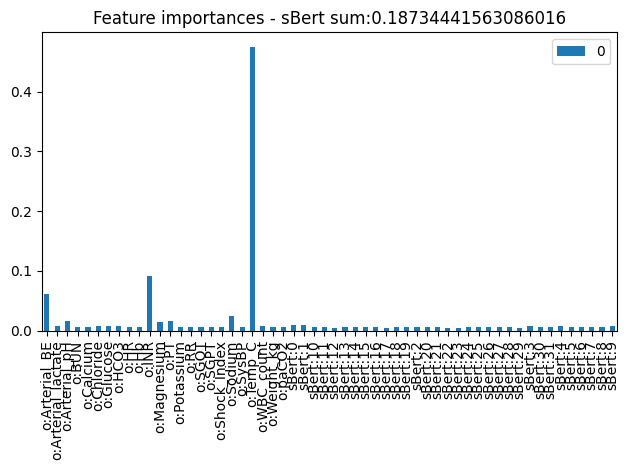

In [307]:
importances = clf_text_sBert[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_text_sBert[1].estimators_], axis=0)
feature_names = var_map_text_sBert*min_step
forest_importances = pd.DataFrame(importances, index=feature_names)
imp = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')
count = imp.loc[imp.index.str.contains('sBert'), imp.columns].sum()
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title(f"Feature importances - sBert sum:{count.item()}")
fig.tight_layout()
